In [98]:
#| echo: False
from PIL import Image
import os
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import keras

## Data
We will begin by loading in the images and resizing them by padding with black pixels. First we get the largest image size and then pad all of the images so that there is a ring of pixels around the images. This allows the neural network to have the same input sizes but still be able to classify differently sized images.

In [2]:
alex_images_path = "Alex_Kelly_Pics/Alex"
kelly_images_path = "Alex_Kelly_Pics/Kelly"
test_images_path = "Alex_Kelly_Pics/TestSet"
image_labels_path = "Kelly_and_Alex_Image_Labels - Sheet1.csv"

In [3]:
def sorted_image_names(path):
    return sorted(os.listdir(path), key=lambda x: int(''.join(filter(str.isdigit, x))))

In [4]:
alex_image_names = sorted_image_names(alex_images_path)
kelly_image_names = sorted_image_names(kelly_images_path)
test_image_names = sorted_image_names(test_images_path)

image_names = alex_image_names + kelly_image_names

In [5]:
labels = pd.read_csv(image_labels_path)
le = LabelEncoder().fit(labels["Landscape"])
labels["Landscape"] = le.transform(labels["Landscape"])
labels

,image_name,Human,Castle,Indoors,Landscape,Woman,Daytime,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food_drink
0,Alex-Image01.png,1,0,0,2,0,1,1,0,0,1,0,0,0,0,0
1,Alex-Image02.png,1,0,0,2,0,1,1,0,0,0,1,0,0,0,0
2,Alex-Image03.png,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,Alex-Image04.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,Alex-Image05.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Kelly-Image225.png,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0
481,Kelly-Image226.png,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0
482,Kelly-Image227.png,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0
483,Kelly-Image228.png,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [6]:
labels['Photographer'] = labels['image_name'].str.split('-', n = 1).str[0]

In [7]:
le = LabelEncoder().fit(labels["Photographer"])
labels["Photographer"] = le.transform(labels["Photographer"])

In [17]:
def get_largest_size(folder):
    biggest_image = [0, 0]
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img.size[0] > biggest_image[0]: 
            biggest_image[0] = img.size[0]
        if img.size[1] > biggest_image[1]:
            biggest_image[1] = img.size[1]
    return biggest_image

In [19]:
alex_im_size = get_largest_size(alex_images_path)
kelly_im_size = get_largest_size(kelly_images_path)
test_im_size = get_largest_size(test_images_path)

print("Max Image Sizes:", max(alex_im_size, kelly_im_size, test_im_size))

Max Image Sizes: [667, 400]


In [21]:
def resize_and_pad(image_path, size=(700, 440)):
    """
    Resize and pad an image to the specified size.
    
    :param image_path: Path to the input image.
    :param output_path: Path to save the output image.
    :param size: Desired output size (width, height).
    """
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    
    # Calculate new size while maintaining aspect ratio
    ratio = min(size[0]/original_size[0], size[1]/original_size[1])
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    resized_image = image.resize(new_size)
    
    # Create a new image with the desired size and pad the resized image
    new_image = Image.new("RGB", size, (0, 0, 0))  # Change color (0, 0, 0) to your desired padding color
    new_image.paste(resized_image, ((size[0] - new_size[0]) // 2, (size[1] - new_size[1]) // 2))
    
    # new_image.save(output_path)
    return new_image

In [23]:
def load_images_from_folder(folder, resize_shape=(700, 440)):
    images = []
    new_images = []
    image_names = []
    count = 0
    for filename in os.listdir(folder):
        count += 1
        # img = Image.open(os.path.join(folder, filename)).convert('RGB')
        img = resize_and_pad(os.path.join(folder, filename), resize_shape)
        if img is not None:
            img_array = np.array(img)
            img_array = img_array.flatten()
            attr = labels[labels["image_name"] == filename].drop("image_name", axis = 1).to_numpy()
            img_array = np.append(img_array, attr)
            images.append(img_array)
            
        if count % int(len(os.listdir(folder)) / 10) == 0:
            print(f"{count / len(os.listdir(folder))*100}% Complete")
    return images

In [31]:
alex_images = load_images_from_folder(alex_images_path)
kelly_images = load_images_from_folder(kelly_images_path)
test_images = load_images_from_folder(test_images_path)

9.765625% Complete
19.53125% Complete
29.296875% Complete
39.0625% Complete
48.828125% Complete
58.59375% Complete
68.359375% Complete
78.125% Complete
87.890625% Complete
97.65625% Complete
9.606986899563319% Complete
19.213973799126638% Complete
28.82096069868996% Complete
38.427947598253276% Complete
48.03493449781659% Complete
57.64192139737992% Complete
67.24890829694323% Complete
76.85589519650655% Complete
86.46288209606988% Complete
96.06986899563319% Complete
10.0% Complete
20.0% Complete
30.0% Complete
40.0% Complete
50.0% Complete
60.0% Complete
70.0% Complete
80.0% Complete
90.0% Complete
100.0% Complete


In [32]:
test_images = np.array(test_images)
test_images = test_images / 255.0
test_images = test_images.reshape(test_images.shape[0], 700, 440, 3)

In [33]:
merged_dataset = np.concatenate([alex_images, kelly_images])
del(alex_images, kelly_images) # Free up memory
merged_dataset

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [37]:
num_attributes = labels.shape[1] - 1

attribute_index = list(range(924000, 924000+num_attributes))

attributes = [col for col in labels.columns if col != "image_name"]

attr_dict = dict(zip(attributes, attribute_index))
attr_dict

{'Human': 924000,
 'Castle': 924001,
 'Indoors': 924002,
 'Landscape': 924003,
 'Woman': 924004,
 'Daytime': 924005,
 'Children': 924006,
 'Sunset': 924007,
 'Flower': 924008,
 'Animal': 924009,
 'Building': 924010,
 'Mask': 924011,
 'Gray-Hair': 924012,
 'Fire': 924013,
 'Food_drink': 924014,
 'Photographer': 924015}

In [160]:
# np.savetxt(X = merged_dataset, fname = "Complete_training_data.csv", delimiter=",")

# Approach 1
We will begin by building Convelutional Neural Networks to attempt to classify 14 different features in the image set. We will then use these images to predict these features for a set of test images. Then we will train one final model using the features as inputs and the photographer of the picture as the target variable. We will then test the model by feeding it the test image predicted features.

## CNN - Human

In [164]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Human"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [165]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [168]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.6915 - loss: 4.0867 - val_accuracy: 0.7377 - val_loss: 0.6231 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.7107 - loss: 0.5795 - val_accuracy: 0.7213 - val_loss: 0.5572 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.7493 - loss: 0.5021 - val_accuracy: 0.7295 - val_loss: 0.5362 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.7438 - loss: 0.5087 - val_accuracy: 0.7049 - val_loss: 0.5724 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.7521 - loss: 0.5189 - val_accuracy: 0.7049 - val_loss: 0.5775 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.7576 - loss: 0.4807 - val_accuracy: 0.7131 - val_loss: 0.5804 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 19s - 2s/step - accuracy: 0.7603 - loss: 0.4825 - val_accuracy: 0.6967 - val_loss: 0.5939 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [169]:
Human_predictions = model.predict(test_images)

Human_predictions = (Human_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


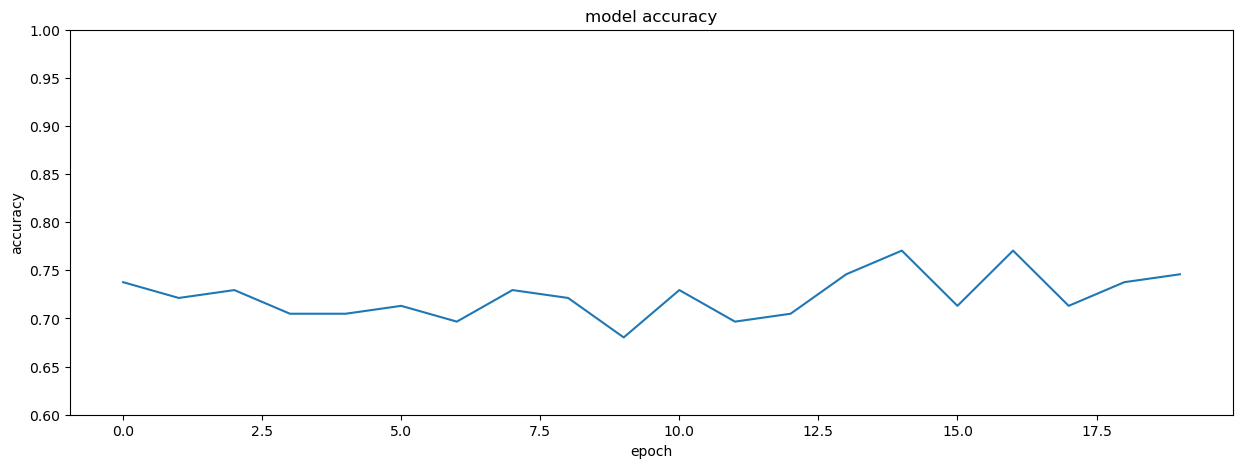

In [170]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60,1])
plt.show()

## CNN - Castle

In [171]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Castle"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [172]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [173]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.8540 - loss: 2.4484 - val_accuracy: 0.9426 - val_loss: 0.2644 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.2913 - val_accuracy: 0.9426 - val_loss: 0.2317 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9229 - loss: 0.2535 - val_accuracy: 0.8934 - val_loss: 0.3097 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.2292 - val_accuracy: 0.9098 - val_loss: 0.2650 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2113 - val_accuracy: 0.9262 - val_loss: 0.2706 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2187 - val_accuracy: 0.9344 - val_loss: 0.2429 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2022 - val_accuracy: 0.9262 - val_loss: 0.2953 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [174]:
Castle_predictions = model.predict(test_images)

Castle_predictions = (Castle_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


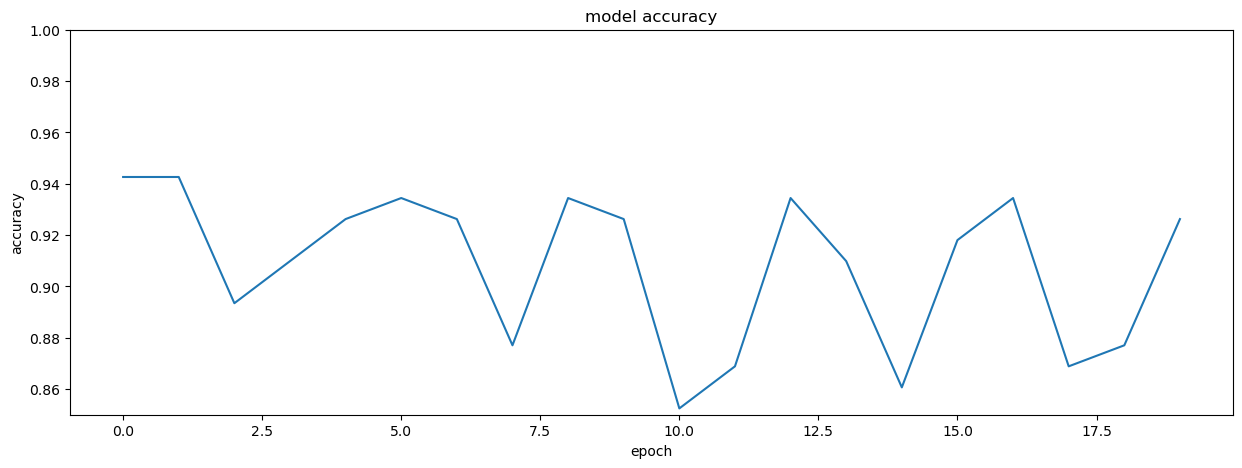

In [175]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.85,1])
plt.show()

## CNN - Indoors

In [176]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Indoors"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [177]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [178]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.6116 - loss: 5.7953 - val_accuracy: 0.7951 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.7851 - loss: 0.4745 - val_accuracy: 0.7869 - val_loss: 0.4539 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.7769 - loss: 0.4155 - val_accuracy: 0.7869 - val_loss: 0.3947 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.7796 - loss: 0.3653 - val_accuracy: 0.8033 - val_loss: 0.3499 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.7879 - loss: 0.3663 - val_accuracy: 0.8115 - val_loss: 0.3914 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.8292 - loss: 0.3843 - val_accuracy: 0.8197 - val_loss: 0.3557 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.8347 - loss: 0.3560 - val_accuracy: 0.7951 - val_loss: 0.3405 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [179]:
Indoor_predictions = model.predict(test_images)

Indoor_predictions = (Indoor_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


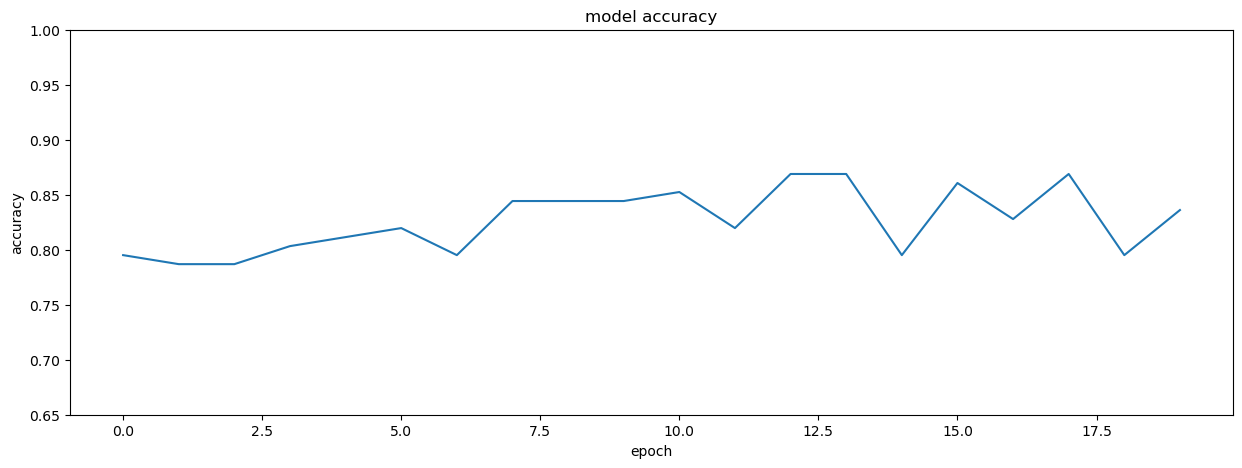

In [180]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.65,1])
plt.show()

## CNN - Landscape

In [181]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Landscape"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [182]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [183]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.3471 - loss: 6.7050 - val_accuracy: 0.4590 - val_loss: 1.7199 - learning_rate: 0.0010
Epoch 2/20
12/12 - 19s - 2s/step - accuracy: 0.4242 - loss: 1.3216 - val_accuracy: 0.2049 - val_loss: 1.2806 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.4573 - loss: 1.1646 - val_accuracy: 0.4508 - val_loss: 1.1965 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.4959 - loss: 1.1092 - val_accuracy: 0.4672 - val_loss: 1.1825 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.5014 - loss: 1.0983 - val_accuracy: 0.4508 - val_loss: 1.1588 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.5096 - loss: 1.0578 - val_accuracy: 0.4508 - val_loss: 1.1673 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 1.0638 - val_accuracy: 0.4754 - val_loss: 1.1388 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [184]:
Landscape_predictions = model.predict(test_images)

Landscape_predictions = np.argmax(Landscape_predictions, axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


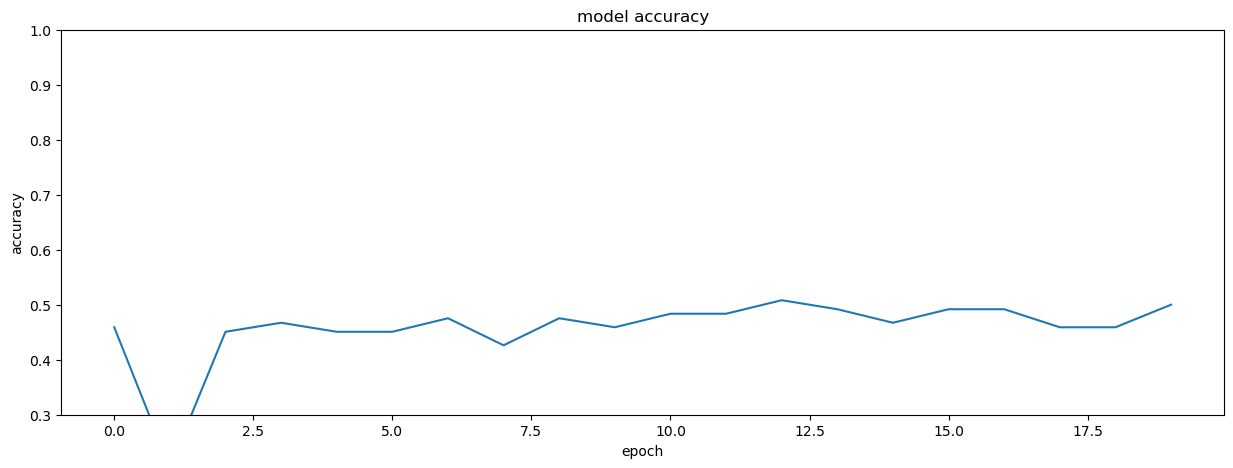

In [185]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.30, 1])
plt.show()

## CNN - Woman

In [186]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Woman"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [187]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [188]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.6777 - loss: 2.7473 - val_accuracy: 0.8689 - val_loss: 0.4024 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3820 - val_accuracy: 0.8689 - val_loss: 0.3934 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3736 - val_accuracy: 0.8689 - val_loss: 0.4051 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3815 - val_accuracy: 0.8689 - val_loss: 0.4382 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3724 - val_accuracy: 0.8689 - val_loss: 0.4255 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3714 - val_accuracy: 0.8689 - val_loss: 0.4519 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.8760 - loss: 0.3895 - val_accuracy: 0.8689 - val_loss: 0.4053 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [189]:
Woman_predictions = model.predict(test_images)

Woman_predictions = (Woman_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


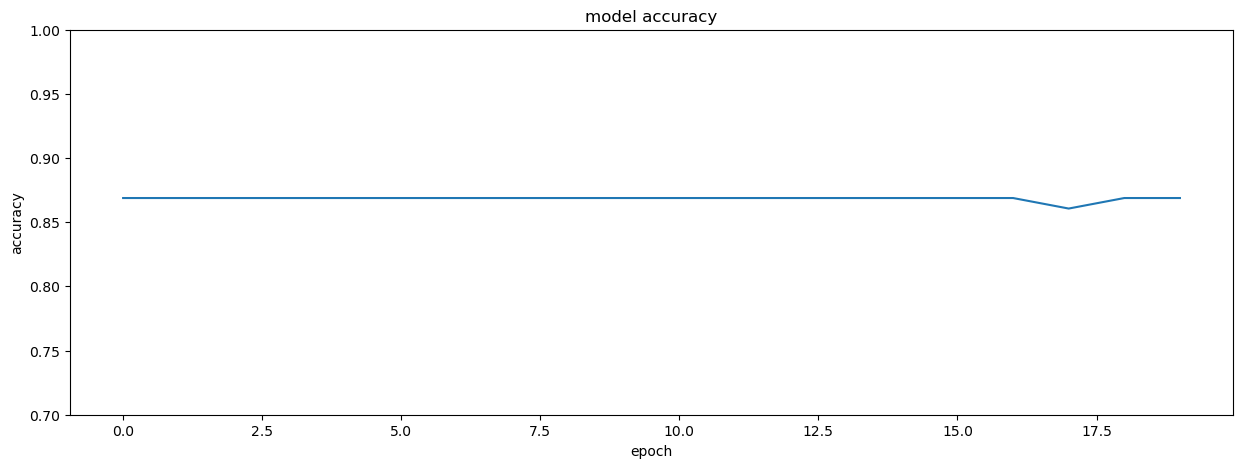

In [190]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.70, 1])
plt.show()

## CNN - Daytime

In [191]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Daytime"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [192]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [193]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.6336 - loss: 2.3485 - val_accuracy: 0.7705 - val_loss: 0.5095 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.8017 - loss: 0.4795 - val_accuracy: 0.7705 - val_loss: 0.5264 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.8017 - loss: 0.4488 - val_accuracy: 0.7705 - val_loss: 0.5878 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.7521 - loss: 0.5056 - val_accuracy: 0.7705 - val_loss: 0.5185 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.8182 - loss: 0.4308 - val_accuracy: 0.7787 - val_loss: 0.4964 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.8209 - loss: 0.4207 - val_accuracy: 0.7787 - val_loss: 0.5085 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.8154 - loss: 0.4640 - val_accuracy: 0.7787 - val_loss: 0.5451 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [194]:
Daytime_predictions = model.predict(test_images)

Daytime_predictions = (Daytime_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


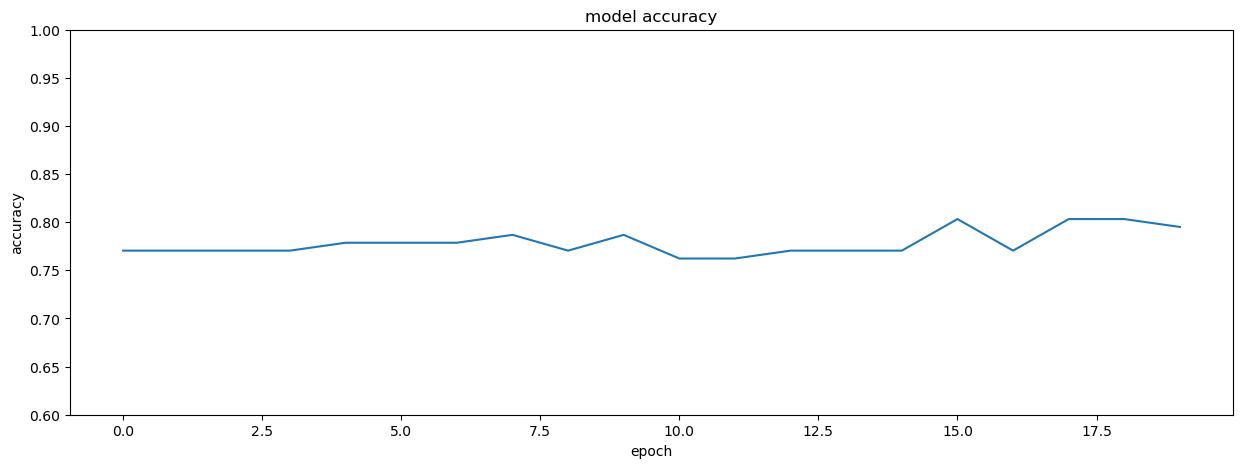

In [195]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.60, 1])
plt.show()

## CNN - Children

In [196]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Children"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [197]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [198]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 21s - 2s/step - accuracy: 0.7466 - loss: 1.9340 - val_accuracy: 0.8852 - val_loss: 0.3629 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.3012 - val_accuracy: 0.8852 - val_loss: 0.3314 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.2435 - val_accuracy: 0.8852 - val_loss: 0.4806 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.2198 - val_accuracy: 0.8852 - val_loss: 0.5972 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.2769 - val_accuracy: 0.8852 - val_loss: 0.3686 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.2438 - val_accuracy: 0.8852 - val_loss: 0.3583 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.2078 - val_accuracy: 0.8852 - val_loss: 0.3674 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [199]:
Child_predictions = model.predict(test_images)

Child_predictions = (Child_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


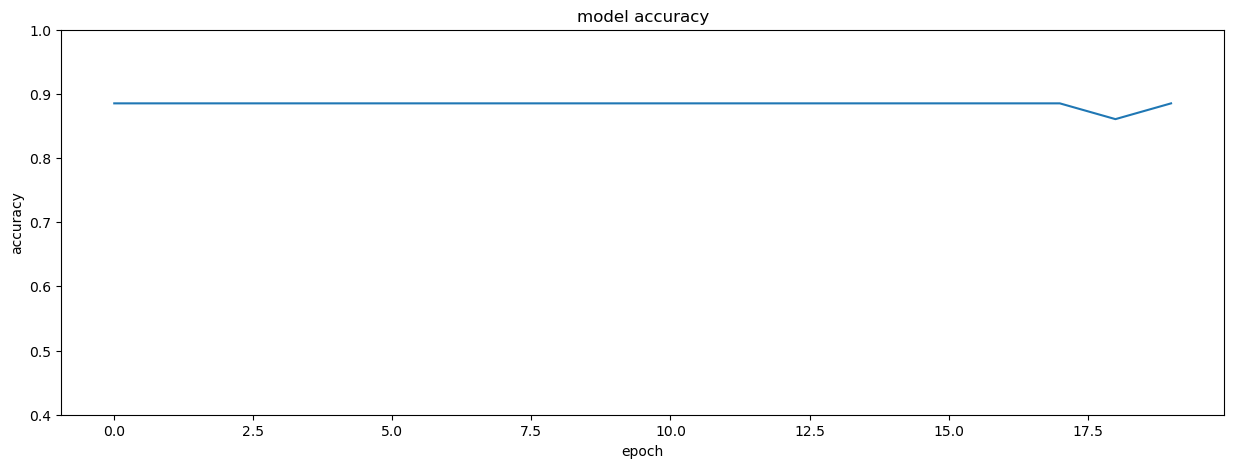

In [200]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.40, 1])
plt.show()

## CNN - Sunset

In [39]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Sunset"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [41]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.8705 - loss: 2.5068 - val_accuracy: 0.9344 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.3020 - val_accuracy: 0.9344 - val_loss: 0.2224 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9146 - loss: 0.2405 - val_accuracy: 0.9344 - val_loss: 0.1722 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.1978 - val_accuracy: 0.9344 - val_loss: 0.1749 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9256 - loss: 0.1968 - val_accuracy: 0.9344 - val_loss: 0.1857 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9284 - loss: 0.1735 - val_accuracy: 0.9262 - val_loss: 0.2072 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.2023 - val_accuracy: 0.9590 - val_loss: 0.1825 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 19s - 2s/step - accuracy: 

In [45]:
Sunset_predictions = model.predict(test_images)

Sunset_predictions = (Sunset_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


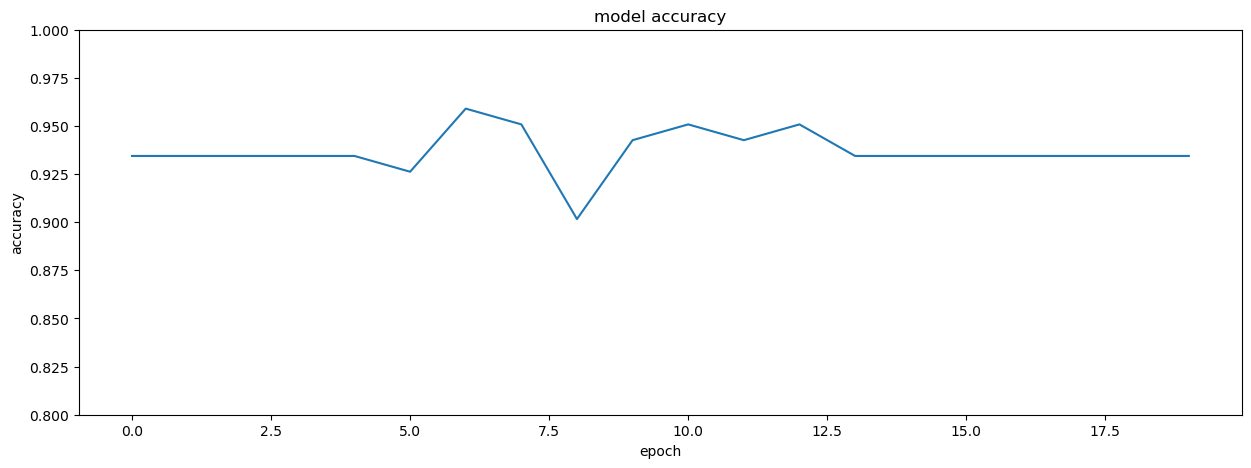

In [47]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.80, 1])
plt.show()

## CNN - Flower

In [53]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Flower"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [55]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.7989 - loss: 1.4766 - val_accuracy: 0.9590 - val_loss: 0.4061 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.2104 - val_accuracy: 0.9590 - val_loss: 0.2232 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.1877 - val_accuracy: 0.9590 - val_loss: 0.2090 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.1857 - val_accuracy: 0.9590 - val_loss: 0.2270 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.1835 - val_accuracy: 0.9590 - val_loss: 0.2198 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.1833 - val_accuracy: 0.9590 - val_loss: 0.2765 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9532 - loss: 0.1686 - val_accuracy: 0.9590 - val_loss: 0.2239 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [59]:
Flower_predictions = model.predict(test_images)

Flower_predictions = (Flower_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


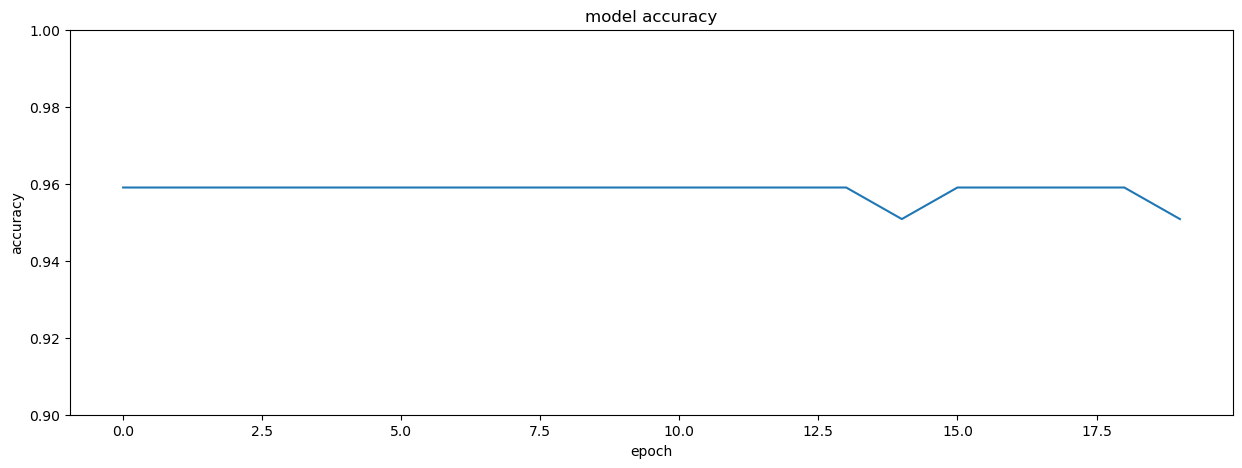

In [63]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

## CNN - Animal

In [70]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Animal"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [72]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [74]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.8264 - loss: 2.5392 - val_accuracy: 0.9508 - val_loss: 0.1989 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9229 - loss: 0.2919 - val_accuracy: 0.9508 - val_loss: 0.1877 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9256 - loss: 0.2558 - val_accuracy: 0.9426 - val_loss: 0.2035 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9229 - loss: 0.2960 - val_accuracy: 0.9426 - val_loss: 0.2001 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9256 - loss: 0.2589 - val_accuracy: 0.9426 - val_loss: 0.2362 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9201 - loss: 0.2695 - val_accuracy: 0.9508 - val_loss: 0.2305 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9229 - loss: 0.2539 - val_accuracy: 0.9508 - val_loss: 0.1878 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [76]:
Animal_predictions = model.predict(test_images)

Animal_predictions = (Animal_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


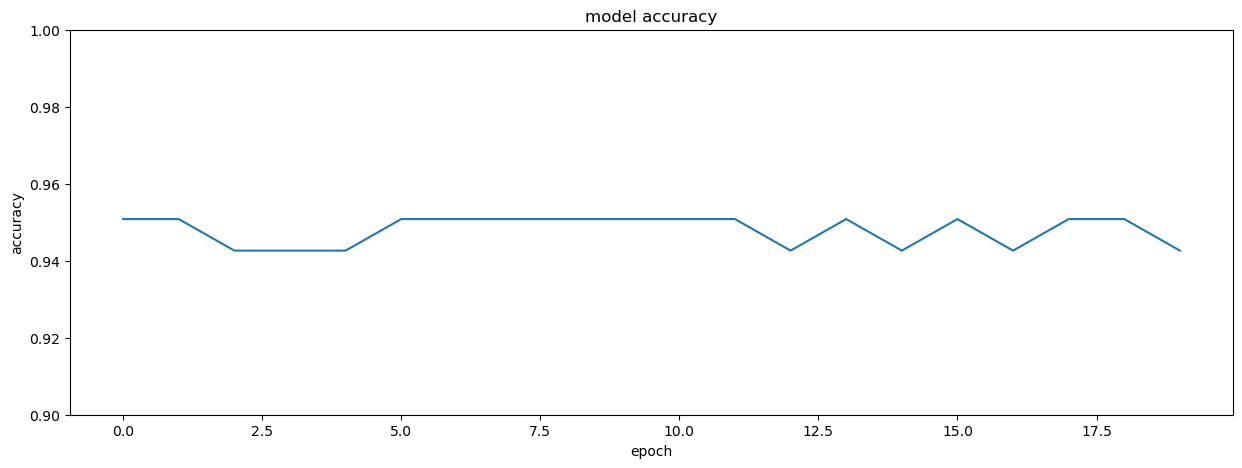

In [78]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

## CNN - Building

In [84]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Building"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [86]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [88]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.5289 - loss: 5.1040 - val_accuracy: 0.5000 - val_loss: 0.6969 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.5289 - loss: 0.6959 - val_accuracy: 0.5000 - val_loss: 0.6938 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6933 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 0.6921 - val_accuracy: 0.5000 - val_loss: 0.6929 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.5317 - loss: 0.6920 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [90]:
Building_predictions = model.predict(test_images)

Building_predictions = (Building_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


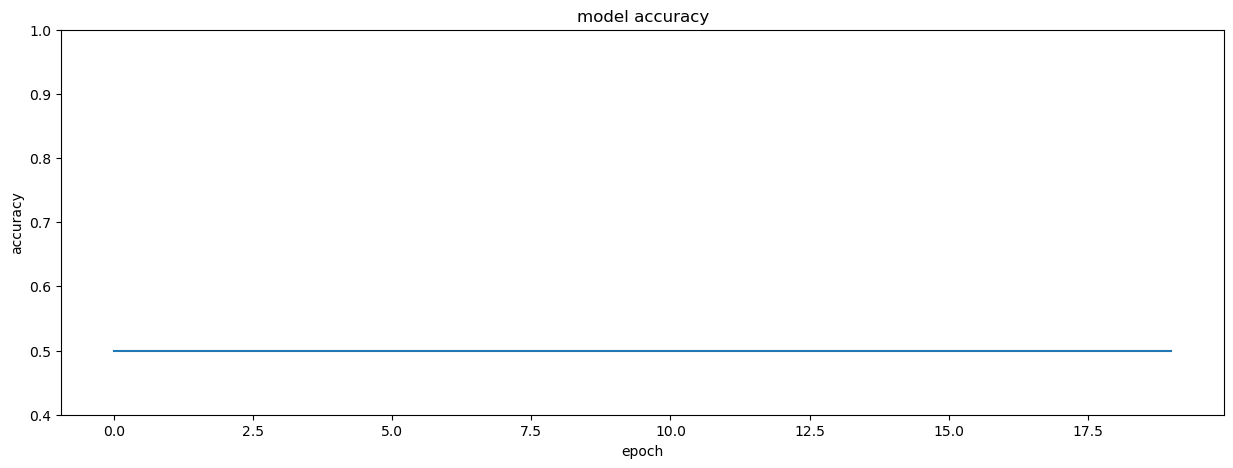

In [94]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.40, 1])
plt.show()

## CNN - Mask

In [98]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Mask"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [100]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [102]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.9063 - loss: 0.7706 - val_accuracy: 0.9754 - val_loss: 0.1334 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0868 - val_accuracy: 0.9754 - val_loss: 0.1385 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0786 - val_accuracy: 0.9754 - val_loss: 0.1695 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0768 - val_accuracy: 0.9754 - val_loss: 0.1330 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0963 - val_accuracy: 0.9754 - val_loss: 0.1761 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0655 - val_accuracy: 0.9754 - val_loss: 0.1354 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9862 - loss: 0.0816 - val_accuracy: 0.9754 - val_loss: 0.1511 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [104]:
Mask_predictions = model.predict(test_images)

Mask_predictions = (Mask_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


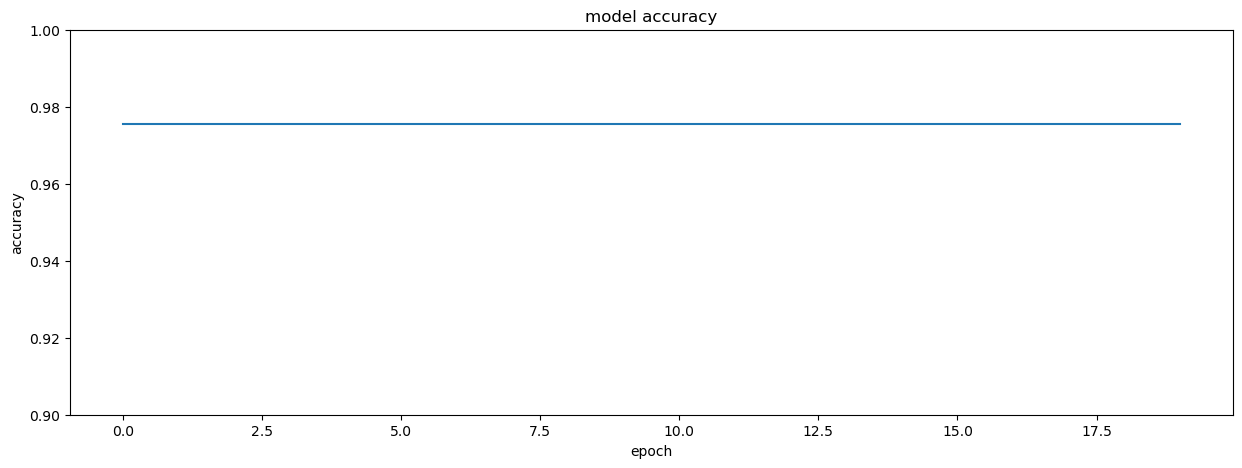

In [106]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

## CNN - Gray Hair

In [112]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Gray-Hair"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [114]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [116]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.8457 - loss: 1.8191 - val_accuracy: 0.9344 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.2130 - val_accuracy: 0.9344 - val_loss: 0.2446 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.2049 - val_accuracy: 0.9344 - val_loss: 0.6002 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.2717 - val_accuracy: 0.9344 - val_loss: 0.7115 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.2344 - val_accuracy: 0.9344 - val_loss: 0.2431 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.1680 - val_accuracy: 0.9344 - val_loss: 0.2436 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9559 - loss: 0.1651 - val_accuracy: 0.9344 - val_loss: 0.2422 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [118]:
GrayHair_predictions = model.predict(test_images)

GrayHair_predictions = (GrayHair_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


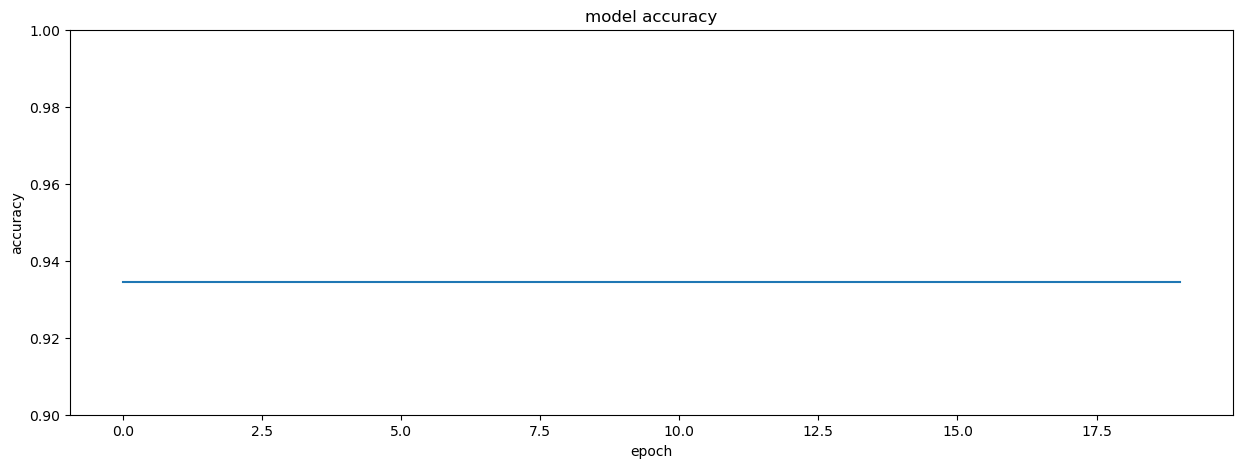

In [120]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

## CNN - Fire

In [126]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Fire"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [128]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.9118 - loss: 3.2884 - val_accuracy: 0.9508 - val_loss: 0.1395 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0729 - val_accuracy: 0.9754 - val_loss: 0.1146 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0419 - val_accuracy: 0.9754 - val_loss: 0.0978 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0235 - val_accuracy: 0.9754 - val_loss: 0.2062 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0895 - val_accuracy: 0.9754 - val_loss: 0.0746 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0363 - val_accuracy: 0.9754 - val_loss: 0.1195 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9945 - loss: 0.0316 - val_accuracy: 0.9754 - val_loss: 0.1313 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [131]:
Fire_predictions = model.predict(test_images)

Fire_predictions = (Fire_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


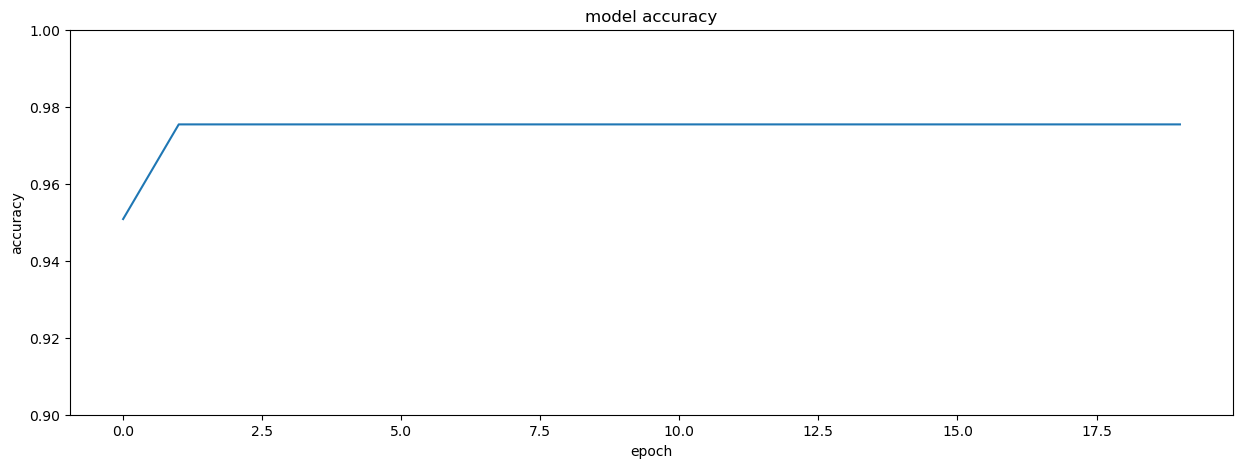

In [132]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

## CNN - Food/Drink

In [140]:
X = merged_dataset[:, 0:924000]
X = X / 255.0
y = merged_dataset[:, attr_dict["Food_drink"]]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = X_train.reshape(X_train.shape[0],700,440,3)
X_test = X_test.reshape(X_test.shape[0],700,440,3)

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']

In [142]:
model = Sequential()
model.add(Conv2D(24,kernel_size=5,padding='same',activation='relu',
        input_shape=(700,440,3)))
model.add(MaxPool2D())
model.add(Conv2D(48,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size=5,padding='same',activation='relu'))
model.add(MaxPool2D(padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

C:\Users\Bnkes\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [144]:
epochs = 20
history = model.fit(X_train, y_train, batch_size=32, epochs = epochs, 
validation_data = (X_test, y_test), callbacks=[annealer], verbose=2)

Epoch 1/20
12/12 - 20s - 2s/step - accuracy: 0.8733 - loss: 2.2901 - val_accuracy: 0.9426 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 2/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2785 - val_accuracy: 0.9426 - val_loss: 0.2180 - learning_rate: 9.5000e-04
Epoch 3/20
12/12 - 18s - 2s/step - accuracy: 0.9311 - loss: 0.3021 - val_accuracy: 0.9426 - val_loss: 0.1970 - learning_rate: 9.0250e-04
Epoch 4/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2545 - val_accuracy: 0.9426 - val_loss: 0.1868 - learning_rate: 8.5737e-04
Epoch 5/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2281 - val_accuracy: 0.9426 - val_loss: 0.2034 - learning_rate: 8.1451e-04
Epoch 6/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2259 - val_accuracy: 0.9426 - val_loss: 0.1901 - learning_rate: 7.7378e-04
Epoch 7/20
12/12 - 18s - 2s/step - accuracy: 0.9339 - loss: 0.2158 - val_accuracy: 0.9426 - val_loss: 0.1938 - learning_rate: 7.3509e-04
Epoch 8/20
12/12 - 18s - 2s/step - accuracy: 

In [146]:
FoodDrink_predictions = model.predict(test_images)

FoodDrink_predictions = (FoodDrink_predictions >= .5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


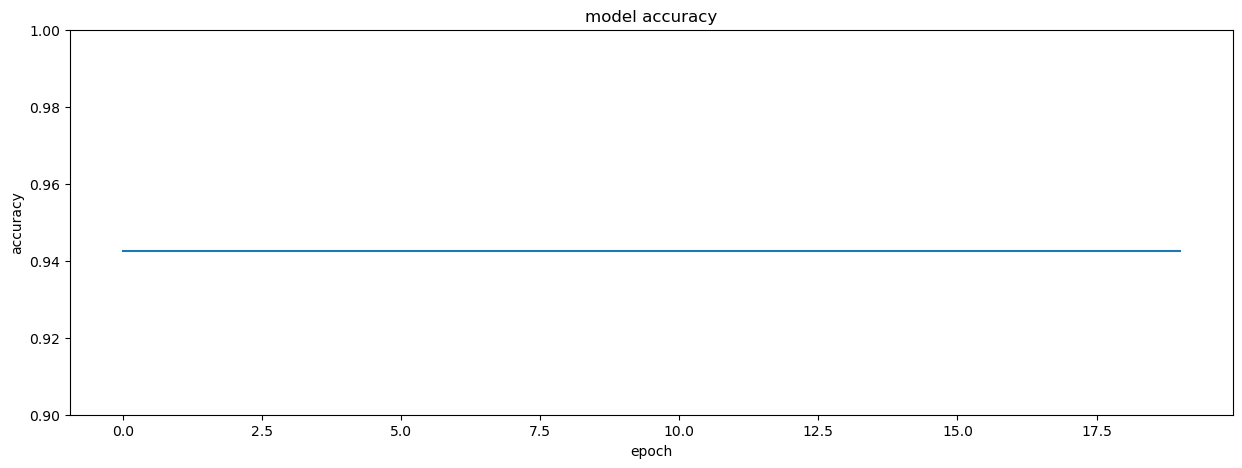

In [148]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.90, 1])
plt.show()

In [264]:
preds = np.concatenate(
    [Human_predictions, Castle_predictions, Indoor_predictions, Landscape_predictions.reshape(20, 1), Woman_predictions, Daytime_predictions, Child_predictions, Sunset_predictions, Flower_predictions, Animal_predictions, Building_predictions, Mask_predictions, GrayHair_predictions, Fire_predictions, FoodDrink_predictions],
    axis = 1
)

pred_df = pd.DataFrame(
    preds,
    columns=["Human", "Castle", "Indoors", "Landscape", "Woman", "Daytime", "Children", "Sunset", "Flower", "Animal", "Building", "Mask", "Gray-Hair", "Fire", "Food/Drink"]
)

## Image Classification

In [25]:
labels

,image_name,Human,Castle,Indoors,Landscape,Woman,Daytime,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food_drink,Photographer
0,Alex-Image01.png,1,0,0,2,0,1,1,0,0,1,0,0,0,0,0,0
1,Alex-Image02.png,1,0,0,2,0,1,1,0,0,0,1,0,0,0,0,0
2,Alex-Image03.png,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,Alex-Image04.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,Alex-Image05.png,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Kelly-Image225.png,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1
481,Kelly-Image226.png,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1
482,Kelly-Image227.png,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
483,Kelly-Image228.png,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


In [27]:
pred_df = pd.read_csv("ImagePredictions.csv").drop("Unnamed: 0", axis = 1)
pred_df

,Human,Castle,Indoors,Landscape,Woman,Daytime,Children,Sunset,Flower,Animal,Building,Mask,Gray-Hair,Fire,Food/Drink
0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
5,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0
6,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0
9,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [45]:
X = labels.drop(["image_name", "Photographer"], axis = 1)
y = labels["Photographer"]

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train = np.array(X_train.values)
X_test = np.array(X_test.values)
y_train = np.array(y_train.values)
y_test = np.array(y_test.values)

test_image_vals = np.array(pred_df)

In [31]:
inputs = keras.Input(shape = (15, ))
x = keras.layers.Dense(30, activation = "relu")(inputs)
x = keras.layers.Dense(60, activation = "relu")(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs=inputs, outputs = outputs, name="image_classification")
model.summary()

Model: "image_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 60)                  │           1,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,401 (9.38 KB)

 Trainable params: 2,401 (9.38 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), optimizer=keras.optimizers.RMSprop(), metrics = ["accuracy"])

history = model.fit(X_train, y_train, batch_size=64, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8310 - loss: 0.3566 - val_accuracy: 0.8607 - val_loss: 0.4600
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8651 - loss: 0.3267 - val_accuracy: 0.8361 - val_loss: 0.4811
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8487 - loss: 0.3237 - val_accuracy: 0.8525 - val_loss: 0.4771
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8226 - loss: 0.3578 - val_accuracy: 0.8525 - val_loss: 0.4678
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8361 - loss: 0.3488 - val_accuracy: 0.8525 - val_loss: 0.4711
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8193 - loss: 0.3635 - val_accuracy: 0.8361 - val_loss: 0.5000
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8431 - loss: 0.3462 - val_accuracy: 0.8361 - val_loss: 0.4919
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8236 - loss: 0.3506 - val_accuracy: 0.8525 - val_loss: 0.4773
Epoch 9

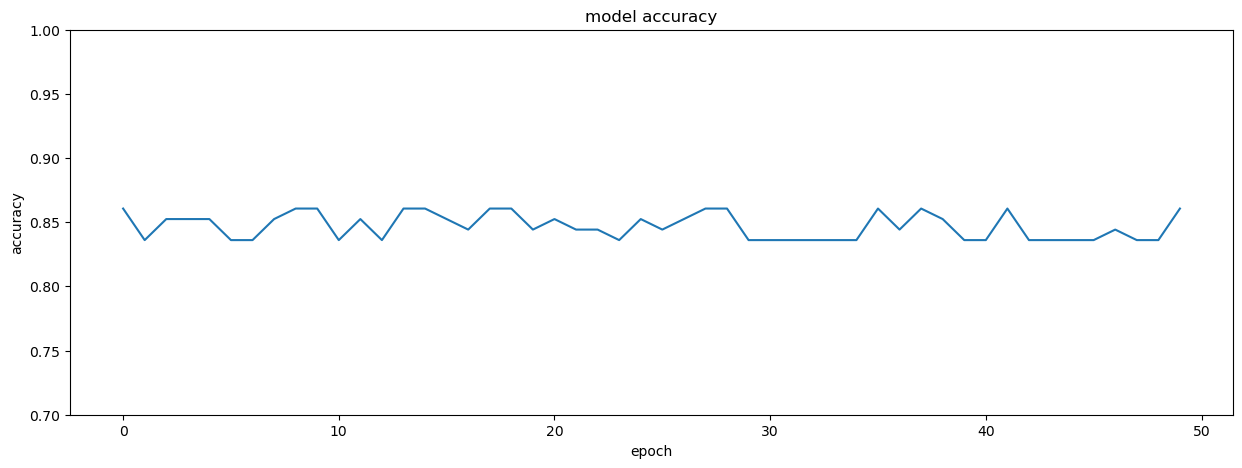

In [43]:
plt.figure(figsize=(15,5))
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
axes = plt.gca()
axes.set_ylim([0.70, 1])
plt.show()

Here are our final predictions via approach 1 for who took each of the test images. 

In [93]:
photographer_pred = model.predict(test_image_vals)

photographer_pred = (photographer_pred >= .5).astype(int)

photographer_dict = {0: "Alex", 1: "Kelly"}
vectorized_function = np.vectorize(lambda x: photographer_dict[x])

photographer_pred = vectorized_function(photographer_pred)

photographer_df = pd.DataFrame(columns=["Image Name", "Predicted Photographer"])
photographer_df["Image Name"] = test_image_names
photographer_df["Predicted Photographer"] = photographer_pred

photographer_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,Image Name,Predicted Photographer
0,TestSetImage01.png,Alex
1,TestSetImage02.png,Alex
2,TestSetImage03.png,Alex
3,TestSetImage04.png,Alex
4,TestSetImage05.png,Alex
5,TestSetImage06.png,Alex
6,TestSetImage07.png,Kelly
7,TestSetImage08.png,Alex
8,TestSetImage09.png,Alex
9,TestSetImage10.png,Kelly


# Approach 2
Now we will attempt to train a Convelutional Neural Network to predict which person took each photo. We will do this by feeding it the known Kelly and Alex images, as well as 